# Compress then explain: example with Feature Effects

Example of CTE with the [`alibi` Python package](https://github.com/SeldonIO/alibi) explaining an XGBoost model trained on the `grid_stability` dataset.

#### load packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost
from goodpoints import compress
import alibi

#### load the dataset and model

In [2]:
task = openml.tasks.get_task(361251, download_data=True, download_splits=False, download_features_meta_data=True, download_qualities=False)
dataset = task.get_dataset()
data = dataset.get_data()
df = data[0]

  return datasets.get_dataset(self.dataset_id)


In [3]:
X = df.drop([dataset.default_target_attribute], axis=1)
y = df[dataset.default_target_attribute]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [5]:
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

In [6]:
grid_points = {i: np.linspace(X_train[:, i].min(), X_train[:, i].max(), 100) for i in range(X_train.shape[1])}

In [7]:
model = xgboost.XGBRegressor(n_estimators=1000, max_depth=5, random_state=0)
model.fit(X_train, y_train)
print('Train score: %.2f' % (model.score(X_train, y_train)))
print('Test score: %.2f' % (model.score(X_test, y_test)))

Train score: 1.00
Test score: 0.94


In [8]:
n = X_test.shape[0]
d = X_test.shape[1]
sigma = np.sqrt(2 * d)

#### compress background data

In [9]:
id_cte = compress.compresspp_kt(X_test, kernel_type=b"gaussian", k_params=np.array([sigma**2]), g=4, seed=0)
X_cte = X_test[id_cte]

#### then explain

In [10]:
explainer_cte = alibi.explainers.PartialDependence(predictor=model.predict, feature_names=X.columns.tolist(), target_names=[y.name])
feature_effects_cte = explainer_cte.explain(X=X_cte, grid_points=grid_points)

In [11]:
ret_cte = pd.DataFrame()
for i, name in enumerate(feature_effects_cte.data['feature_names']):
    ret_cte = pd.concat([ret_cte, pd.DataFrame({
        'feature_values': feature_effects_cte.data['feature_values'][i].flatten(),
        'pd_values': feature_effects_cte.data['pd_values'][i].flatten(),
        'feature_name': name,
        'method': 'cte'
    })])

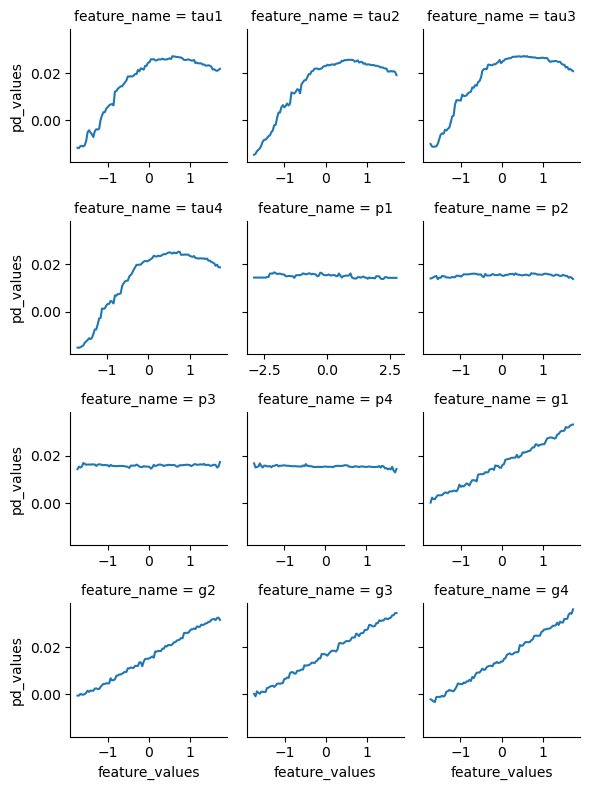

In [12]:
_ = sns.relplot(ret_cte, x='feature_values', y='pd_values', col='feature_name', col_wrap=3, kind='line', facet_kws={'sharex': False}, height=2)

#### compare with iid sampling

In [13]:
np.random.seed(0)
id_iid = np.random.choice(n, size=len(id_cte))
X_iid = X_test[id_iid]

In [14]:
explainer_iid = alibi.explainers.PartialDependence(predictor=model.predict, feature_names=X.columns.tolist(), target_names=[y.name])
feature_effects_iid = explainer_iid.explain(X=X_iid, grid_points=grid_points)

In [15]:
ret_iid = pd.DataFrame()
for i, name in enumerate(feature_effects_iid.data['feature_names']):
    ret_iid = pd.concat([ret_iid, pd.DataFrame({
        'feature_values': feature_effects_iid.data['feature_values'][i].flatten(),
        'pd_values': feature_effects_iid.data['pd_values'][i].flatten(),
        'feature_name': name,
        'method': 'iid'
    })])

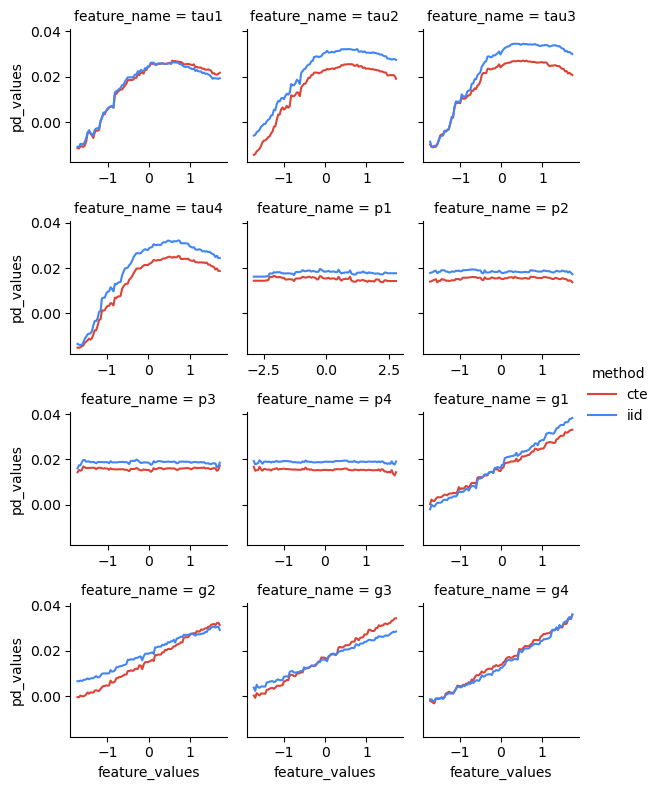

In [16]:
_ = sns.relplot(
    pd.concat([ret_cte, ret_iid], axis=0), 
    x='feature_values', y='pd_values', col='feature_name', col_wrap=3, kind='line', facet_kws={'sharex': False}, height=2,
    hue='method', palette=['#DB4437', '#4285F4']
)

#### calculate "ground truth"

In [17]:
explainer_gt = alibi.explainers.PartialDependence(predictor=model.predict, feature_names=X.columns.tolist(), target_names=[y.name])
feature_effects_gt = explainer_iid.explain(X=X_test, grid_points=grid_points)

In [18]:
ret_gt = pd.DataFrame()
for i, name in enumerate(feature_effects_gt.data['feature_names']):
    ret_iid = pd.concat([ret_iid, pd.DataFrame({
        'feature_values': feature_effects_gt.data['feature_values'][i].flatten(),
        'pd_values': feature_effects_gt.data['pd_values'][i].flatten(),
        'feature_name': name,
        'method': 'gt'
    })])

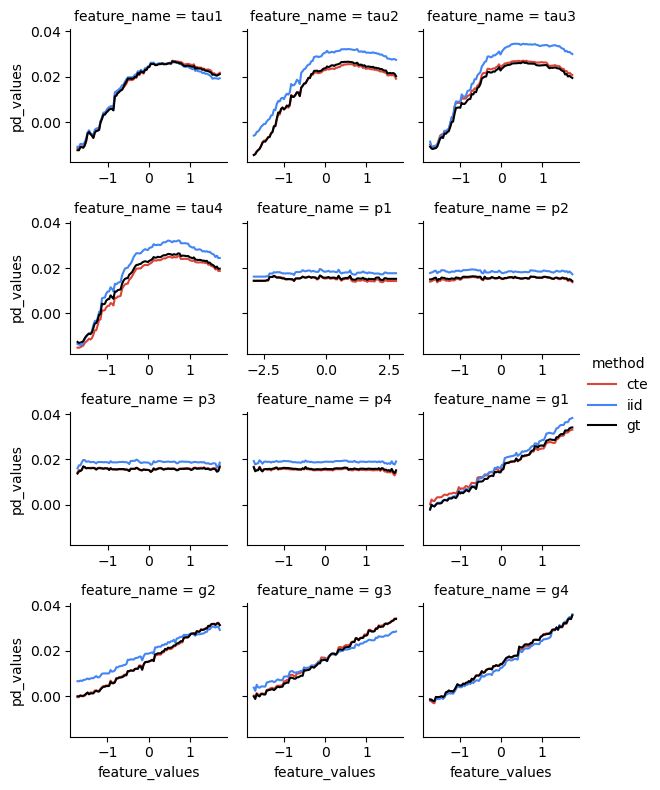

In [19]:
_ = sns.relplot(
    pd.concat([ret_cte, ret_iid, ret_gt], axis=0), 
    x='feature_values', y='pd_values', col='feature_name', col_wrap=3, kind='line', facet_kws={'sharex': False}, height=2,
    hue='method', palette=['#DB4437', '#4285F4', 'black']
)

#### evaluate

In [20]:
def metric_mae(x, y):
    x = np.concatenate(x.pd_values, axis=0)
    y = np.concatenate(y.pd_values, axis=0)
    return np.mean(np.abs(x-y))

In [21]:
error_absolute = metric_mae(feature_effects_gt, feature_effects_iid)
print(f'Explanation approximation error introduced by iid sampling:\
      {error_absolute:.4f}')
error_relative = 100*(metric_mae(feature_effects_gt, feature_effects_iid) - metric_mae(feature_effects_gt, feature_effects_cte)) /\
        metric_mae(feature_effects_gt, feature_effects_iid)
print(f'Relative improvement by CTE: {error_relative:.2f}%')

Explanation approximation error introduced by iid sampling:      0.0032
Relative improvement by CTE: 79.08%
